# Commit Label Analysis & Model Comparison

This notebook analyzes commit messages labeled by 3 local LLM models:
- **phi3:mini** (2.2 GB)
- **llama3.1:8b** (4.9 GB)
- **mistral:7b** (4.4 GB)

We'll compare:
1. Parse success rates and latency
2. Label distributions (type, tone)
3. Model agreement rates
4. Quality assessment

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

OUT = Path("..") / "outputs"
DATA = Path("..") / "data"

## 1. Load Labeling Results

In [2]:
rows = []
for fp in OUT.glob("commit_labels__*.jsonl"):
    with fp.open() as f:
        for i, line in enumerate(f):
            row = json.loads(line)
            row["row_id"] = f"{fp.stem}_{i}"  # unique id
            rows.append(row)

df = pd.DataFrame(rows)
df["ok"] = df["error"].isna() & df["parsed"].notna()

# Add a commit_id based on message order within each model
df["commit_idx"] = df.groupby("model").cumcount()

print(f"Total records: {len(df)}")
print(f"Models: {df['model'].unique().tolist()}")
df.head()

Total records: 69
Models: ['mistral:7b', 'llama3.1:8b', 'phi3:mini']


,model,input_message,parsed,raw_text,latency_s,error,row_id,ok,commit_idx
0,mistral:7b,Create 1772E,"{'type': ['chore'], 'tone': ['neutral'], 'scop...","{\n ""type"": [""chore""],\n ""tone"": [""neutral""...",8.498450,None,commit_labels__mistral_7b_0,True,0
1,mistral:7b,Create 1738C,"{'type': ['chore'], 'tone': ['neutral'], 'scop...","{\n ""type"": [""chore""],\n ""tone"": [""neutral""...",2.847934,None,commit_labels__mistral_7b_1,True,1
2,mistral:7b,Create 1760F,"{'type': ['chore'], 'tone': ['neutral'], 'scop...","{\n ""type"": [""chore""],\n ""tone"": [""neutral""...",2.364777,None,commit_labels__mistral_7b_2,True,2
3,mistral:7b,Create 1842C,"{'type': ['chore'], 'tone': ['neutral'], 'scop...","{\n ""type"": [""chore""],\n ""tone"": [""neutral""...",2.507214,None,commit_labels__mistral_7b_3,True,3
4,mistral:7b,add new stuff,"{'type': ['feat'], 'tone': ['neutral'], 'scope...","{\n ""type"": [""feat""],\n ""tone"": [""neutral""]...",2.428248,None,commit_labels__mistral_7b_4,True,4


## 2. Performance Comparison: Speed & Reliability

In [3]:
summary = df.groupby("model").agg(
    n=("model", "count"),
    parse_success=("ok", "mean"),
    avg_latency_s=("latency_s", "mean"),
    std_latency_s=("latency_s", "std"),
    min_latency_s=("latency_s", "min"),
    max_latency_s=("latency_s", "max"),
).round(3)

summary["parse_success_pct"] = (summary["parse_success"] * 100).round(1).astype(str) + "%"
print("=" * 60)
print("MODEL PERFORMANCE COMPARISON")
print("=" * 60)
summary

MODEL PERFORMANCE COMPARISON


,n,parse_success,avg_latency_s,std_latency_s,min_latency_s,max_latency_s,parse_success_pct
model,,,,,,,
llama3.1:8b,23,1.000,2.568,1.161,2.040,7.285,100.0%
mistral:7b,23,0.913,2.920,1.305,2.279,8.498,91.3%
phi3:mini,23,0.957,2.339,1.502,1.289,7.631,95.7%


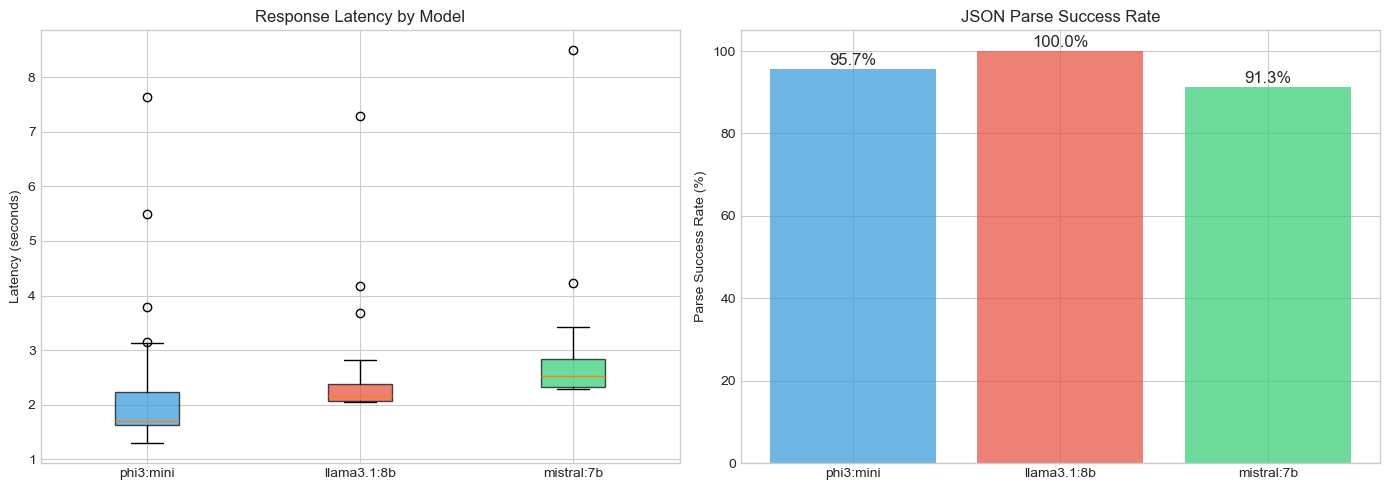

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Define consistent model order and colors
MODEL_ORDER = ["phi3:mini", "llama3.1:8b", "mistral:7b"]
colors = ['#3498db', '#e74c3c', '#2ecc71']

# Latency boxplot
latency_data = [df[df["model"] == m]["latency_s"].values for m in MODEL_ORDER]
bp = axes[0].boxplot(latency_data, labels=MODEL_ORDER, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[0].set_ylabel("Latency (seconds)")
axes[0].set_title("Response Latency by Model")

# Success rate bar chart (same order)
success_rates = df.groupby("model")["ok"].mean().reindex(MODEL_ORDER) * 100
bars = axes[1].bar(MODEL_ORDER, success_rates.values, color=colors, alpha=0.7)
axes[1].set_ylabel("Parse Success Rate (%)")
axes[1].set_title("JSON Parse Success Rate")
axes[1].set_ylim(0, 105)
for bar, rate in zip(bars, success_rates.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                 f"{rate:.1f}%", ha='center', fontsize=12)

plt.tight_layout()
plt.savefig("../outputs/model_performance.png", dpi=150, bbox_inches='tight')
plt.show()

## 3. Extract Labels for Analysis

In [5]:
def safe_get(parsed, key):
    """Safely extract value from parsed dict, handling lists and None."""
    if parsed is None:
        return None
    # Handle case where parsed is a list instead of dict
    if isinstance(parsed, list):
        return None
    if not isinstance(parsed, dict):
        return None
    val = parsed.get(key)
    if isinstance(val, list):
        return val[0] if val else None
    return val

df["type"] = df["parsed"].apply(lambda x: safe_get(x, "type"))
df["tone"] = df["parsed"].apply(lambda x: safe_get(x, "tone"))
df["confidence"] = df["parsed"].apply(lambda x: safe_get(x, "confidence"))
df["scope_guess"] = df["parsed"].apply(lambda x: safe_get(x, "scope_guess"))

# Show distribution
print("Type distribution across all models:")
print(df["type"].value_counts())
print("\nTone distribution across all models:")
print(df["tone"].value_counts())

Type distribution across all models:
type
feat     39
chore    10
other     4
fix       4
merge     2
test      1
Name: count, dtype: int64

Tone distribution across all models:
tone
neutral       36
positive      21
unclear        1
null           1
frustrated     1
Name: count, dtype: int64


## 4. Label Distributions by Model

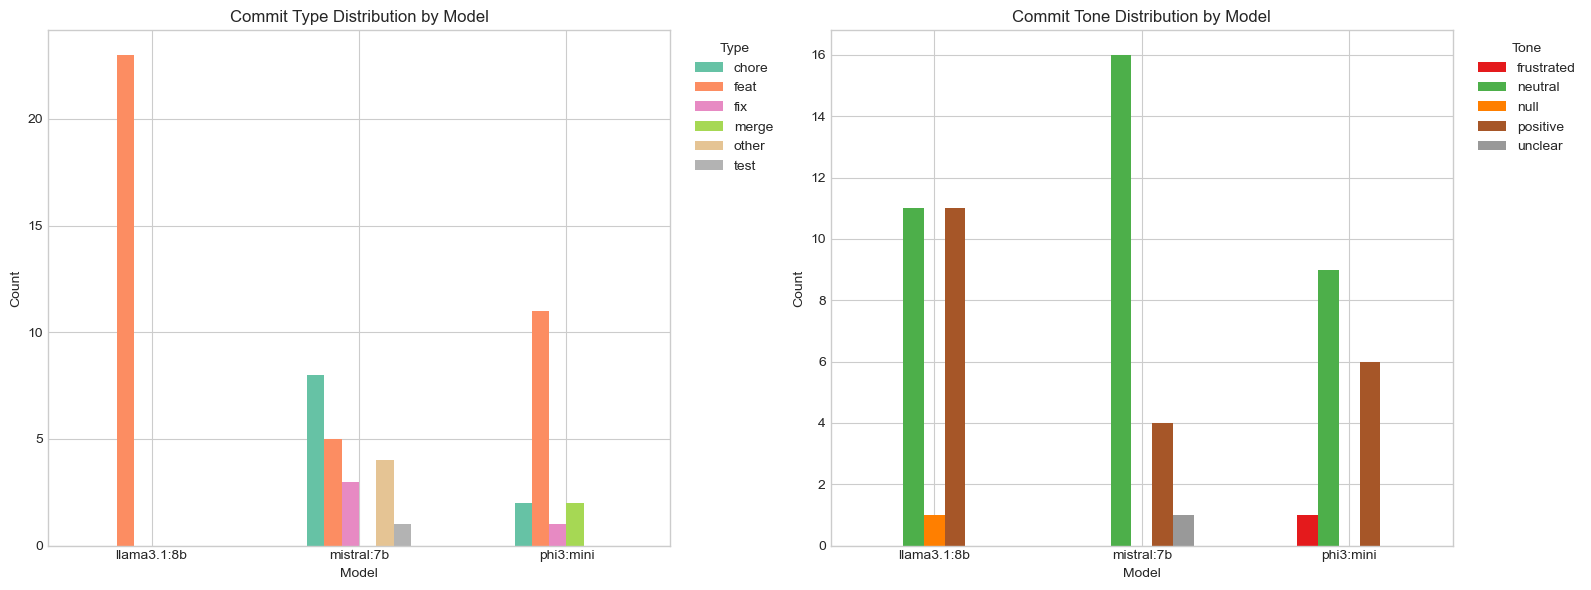

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Type distribution
type_by_model = df.groupby(["model", "type"]).size().unstack(fill_value=0)
type_by_model.plot(kind="bar", ax=axes[0], colormap="Set2")
axes[0].set_title("Commit Type Distribution by Model")
axes[0].set_xlabel("Model")
axes[0].set_ylabel("Count")
axes[0].legend(title="Type", bbox_to_anchor=(1.02, 1), loc='upper left')
axes[0].tick_params(axis='x', rotation=0)

# Tone distribution
tone_by_model = df.groupby(["model", "tone"]).size().unstack(fill_value=0)
tone_by_model.plot(kind="bar", ax=axes[1], colormap="Set1")
axes[1].set_title("Commit Tone Distribution by Model")
axes[1].set_xlabel("Model")
axes[1].set_ylabel("Count")
axes[1].legend(title="Tone", bbox_to_anchor=(1.02, 1), loc='upper left')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig("../outputs/label_distributions.png", dpi=150, bbox_inches='tight')
plt.show()

## 5. Model Agreement Analysis

In [7]:
# Pivot to compare models (use commit_idx to avoid duplicate issues)
pivot_type = df.pivot(index="commit_idx", columns="model", values="type")
pivot_tone = df.pivot(index="commit_idx", columns="model", values="tone")

models = list(pivot_type.columns)
print("MODEL AGREEMENT RATES")
print("=" * 50)

# Calculate pairwise agreement
agreement_matrix = {}
for i, m1 in enumerate(models):
    for m2 in models[i+1:]:
        type_agree = (pivot_type[m1] == pivot_type[m2]).mean()
        tone_agree = (pivot_tone[m1] == pivot_tone[m2]).mean()
        agreement_matrix[(m1, m2)] = {"type": type_agree, "tone": tone_agree}
        print(f"{m1} vs {m2}:")
        print(f"  Type agreement: {type_agree:.1%}")
        print(f"  Tone agreement: {tone_agree:.1%}")
        print()

MODEL AGREEMENT RATES
llama3.1:8b vs mistral:7b:
  Type agreement: 21.7%
  Tone agreement: 60.9%

llama3.1:8b vs phi3:mini:
  Type agreement: 47.8%
  Tone agreement: 47.8%

mistral:7b vs phi3:mini:
  Type agreement: 17.4%
  Tone agreement: 47.8%



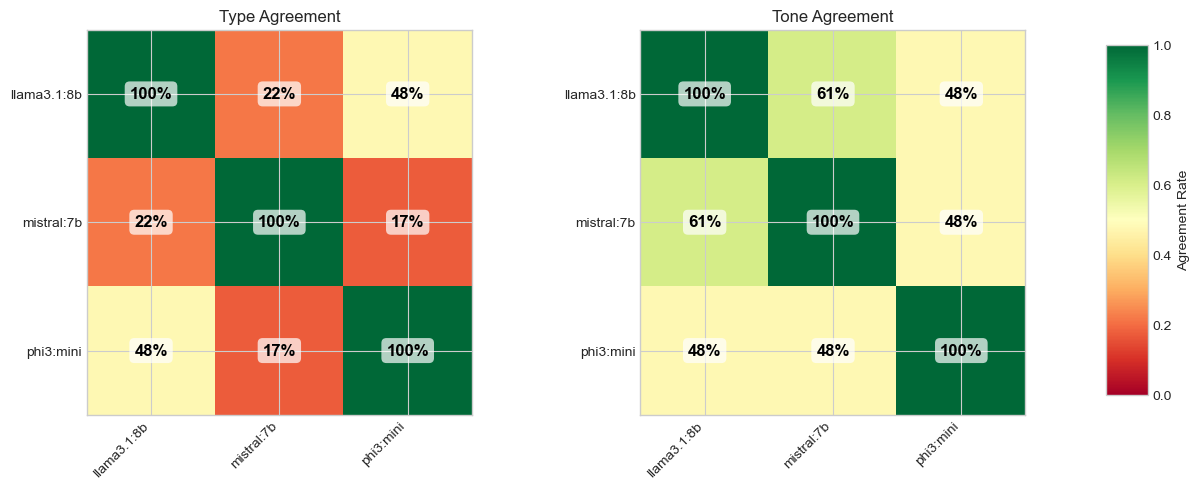

In [8]:
# Create agreement heatmap
n_models = len(models)
type_matrix = np.eye(n_models)
tone_matrix = np.eye(n_models)

for i, m1 in enumerate(models):
    for j, m2 in enumerate(models):
        if i != j:
            key = (m1, m2) if (m1, m2) in agreement_matrix else (m2, m1)
            if key in agreement_matrix:
                type_matrix[i, j] = agreement_matrix[key]["type"]
                tone_matrix[i, j] = agreement_matrix[key]["tone"]

# Create figure with extra space on the right for colorbar
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plt.subplots_adjust(right=0.85)  # Make room for colorbar

for ax, matrix, title in [(axes[0], type_matrix, "Type Agreement"), 
                           (axes[1], tone_matrix, "Tone Agreement")]:
    im = ax.imshow(matrix, cmap='RdYlGn', vmin=0, vmax=1)
    ax.set_xticks(range(n_models))
    ax.set_yticks(range(n_models))
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.set_yticklabels(models)
    ax.set_title(title)
    
    # Add text annotations with better visibility
    for i in range(n_models):
        for j in range(n_models):
            text = ax.text(j, i, f"{matrix[i,j]:.0%}", ha='center', va='center', 
                          fontsize=12, fontweight='bold', color='black',
                          bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                                   alpha=0.7, edgecolor='none'))

# Add colorbar in dedicated space on the right
cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("Agreement Rate")

plt.savefig("../outputs/model_agreement.png", dpi=150, bbox_inches='tight')
plt.show()

## 6. Confidence Analysis

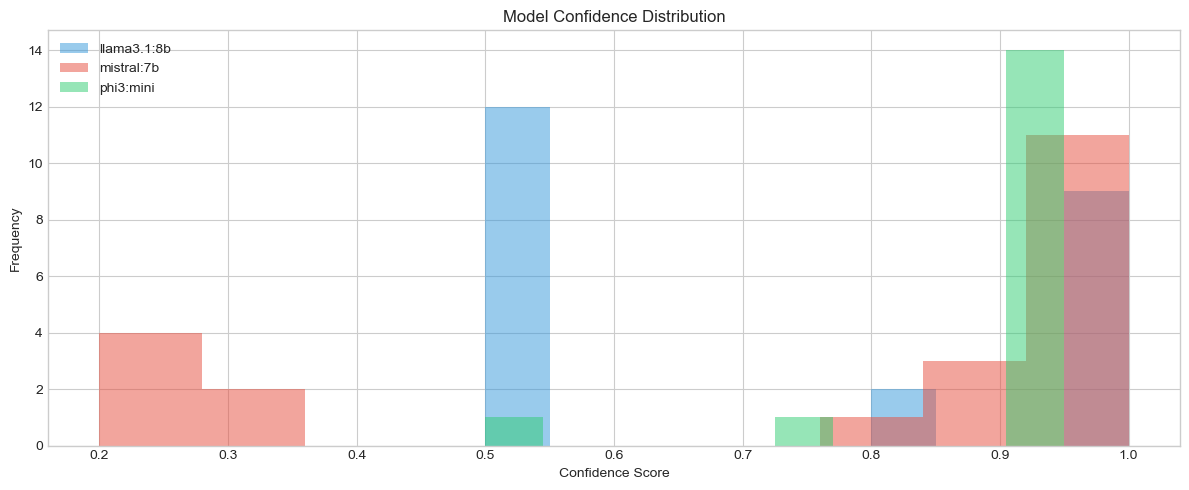


Average Confidence by Model:
model
llama3.1:8b    0.722
mistral:7b     0.733
phi3:mini      0.909
Name: confidence, dtype: float64


In [9]:
fig, ax = plt.subplots(figsize=(12, 5))

for i, model in enumerate(models):
    model_df = df[df["model"] == model]
    conf = model_df["confidence"].dropna()
    ax.hist(conf, bins=10, alpha=0.5, label=model, color=colors[i])

ax.set_xlabel("Confidence Score")
ax.set_ylabel("Frequency")
ax.set_title("Model Confidence Distribution")
ax.legend()
plt.tight_layout()
plt.savefig("../outputs/confidence_distribution.png", dpi=150, bbox_inches='tight')
plt.show()

print("\nAverage Confidence by Model:")
print(df.groupby("model")["confidence"].mean().round(3))

## 7. Disagreement Analysis

In [10]:
# Find commits where models disagree
pivot_type = df.pivot(index="commit_idx", columns="model", values="type")
pivot_msg = df.pivot(index="commit_idx", columns="model", values="input_message")

def all_same(row):
    vals = row.dropna().unique()
    return len(vals) == 1

disagreements = pivot_type[~pivot_type.apply(all_same, axis=1)]

print(f"Commits with model disagreement: {len(disagreements)} / {len(pivot_type)}")
print("\nExamples of disagreements:")
print("=" * 80)
for idx in disagreements.head(5).index:
    # Get the message from any model
    msg = pivot_msg.loc[idx].dropna().iloc[0] if len(pivot_msg.loc[idx].dropna()) > 0 else "Unknown"
    print(f"\nMessage: '{msg[:60]}...'" if len(str(msg)) > 60 else f"\nMessage: '{msg}'")
    for model in models:
        print(f"  {model}: {pivot_type.loc[idx, model]}")

Commits with model disagreement: 16 / 23

Examples of disagreements:

Message: 'Create 1772E'
  llama3.1:8b: feat
  mistral:7b: chore
  phi3:mini: feat

Message: 'Create 1738C'
  llama3.1:8b: feat
  mistral:7b: chore
  phi3:mini: feat

Message: 'Create 1760F'
  llama3.1:8b: feat
  mistral:7b: chore
  phi3:mini: feat

Message: 'Create 1842C'
  llama3.1:8b: feat
  mistral:7b: chore
  phi3:mini: feat

Message: 'new'
  llama3.1:8b: feat
  mistral:7b: chore
  phi3:mini: None


## 8. Summary & Key Findings

In [11]:
print("=" * 70)
print("COMMIT LABEL ANALYSIS - KEY FINDINGS")
print("=" * 70)

# Best performing model
best_speed = summary["avg_latency_s"].idxmin()
best_reliability = summary["parse_success"].idxmax()

print(f"\n1. PERFORMANCE:")
print(f"   - Fastest model: {best_speed} ({summary.loc[best_speed, 'avg_latency_s']:.2f}s avg)")
print(f"   - Most reliable: {best_reliability} ({summary.loc[best_reliability, 'parse_success']:.1%} success)")

print(f"\n2. COMMIT PATTERNS:")
most_common_type = df["type"].value_counts().idxmax()
most_common_tone = df["tone"].value_counts().idxmax()
print(f"   - Most common type: {most_common_type}")
print(f"   - Most common tone: {most_common_tone}")

print(f"\n3. MODEL AGREEMENT:")
for (m1, m2), rates in agreement_matrix.items():
    print(f"   - {m1} vs {m2}: {rates['type']:.0%} type, {rates['tone']:.0%} tone")

print(f"\n4. INSIGHTS:")
print(f"   - Total commits analyzed: {len(pivot_type)}")
print(f"   - Commits with unanimous agreement: {len(pivot_type) - len(disagreements)}")
print(f"   - Commits with disagreement: {len(disagreements)}")

COMMIT LABEL ANALYSIS - KEY FINDINGS

1. PERFORMANCE:
   - Fastest model: phi3:mini (2.34s avg)
   - Most reliable: llama3.1:8b (100.0% success)

2. COMMIT PATTERNS:
   - Most common type: feat
   - Most common tone: neutral

3. MODEL AGREEMENT:
   - llama3.1:8b vs mistral:7b: 22% type, 61% tone
   - llama3.1:8b vs phi3:mini: 48% type, 48% tone
   - mistral:7b vs phi3:mini: 17% type, 48% tone

4. INSIGHTS:
   - Total commits analyzed: 23
   - Commits with unanimous agreement: 7
   - Commits with disagreement: 16
